## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Test amplitude distribution

Test distribution shapre:
$$
P = \begin{cases}1.6E\text{, "uphill"}\\ 3.2-0.25E\text{, "downhill"}\end{cases}
$$
$0 \le E \le 15$

Let's find intersection point:
$$1.6E = 3.2-0.25E$$
$$1.85E = 3.2$$

In [2]:
E_test = np.linspace(0, 15, 1000)

In [3]:
P_test = np.array([ 1.6*E if E < 3.2/1.85 else (3.2 - 0.25*E) for E in E_test ])
P_test[P_test < 0] = 0

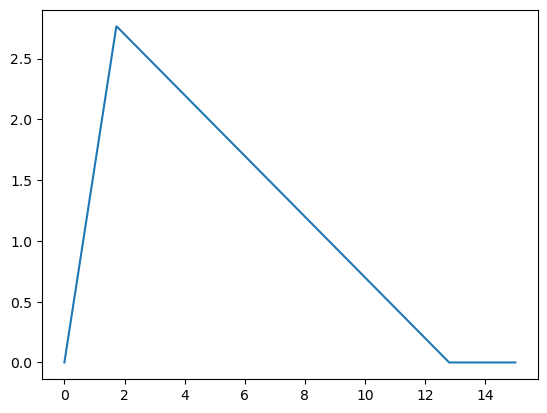

In [4]:
plt.plot(E_test, P_test)

### Normalize the test set

In [5]:
def probNormalize(E, P):
    # Integrate P
    PInt = 0
    for i in range(len(E) - 1):
        PInt += (P[i] + P[i+1]) * (E[i+1] - E[i]) / 2
    print(f"{PInt=}")
    return P / PInt

In [6]:
P_test = probNormalize(E_test, P_test)

PInt=17.71240609979348


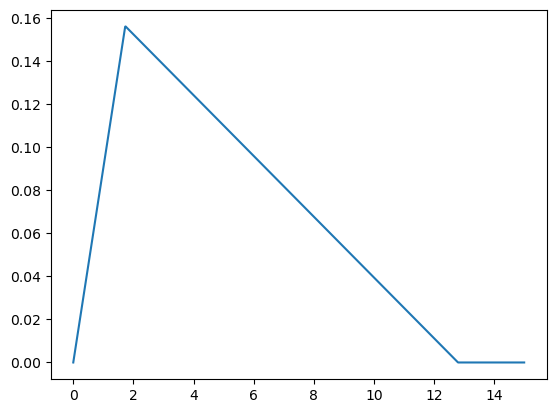

In [7]:
plt.plot(E_test, P_test)

In [8]:
assert(np.allclose(probNormalize(E_test, P_test), P_test))

PInt=1.0000000000000004


## Load the example signal

In [9]:
exampleSignal = ( [], [] )
with open('task/Shape_Etalon.txt') as sigFile:
    for line in sigFile.readlines():
        point = line.split('\t')
        for i in range(2):
            exampleSignal[i].append(float(point[i]))
exampleSignal = ( np.array(exampleSignal[0]), np.array(exampleSignal[1]) )

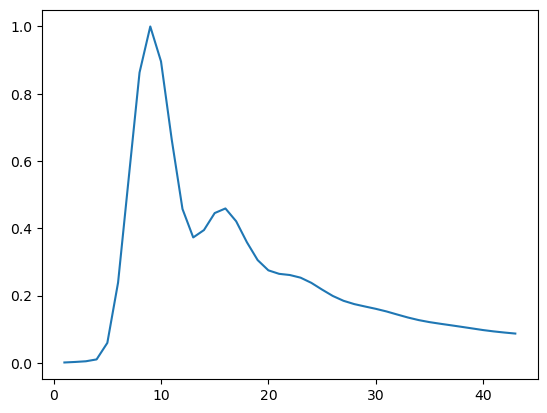

In [10]:
plt.plot(exampleSignal[0], exampleSignal[1])

### Utility - plot signal

In [11]:
def plotSignals(*signals, **namedSignals):
    for idx, signal in enumerate(signals):
        plt.plot(signal[0], signal[1], label=f"Signal {idx}")
    for name in namedSignals:
        plt.plot(namedSignals[name][0], namedSignals[name][1], label=name)
    plt.legend()

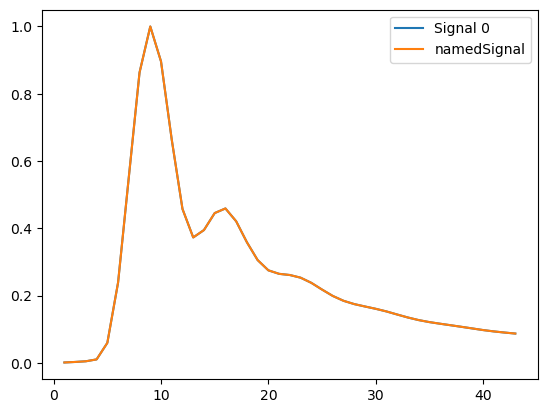

In [12]:
plotSignals(exampleSignal, namedSignal=exampleSignal)

## Signal composition

In [13]:
def composeSignals(signal1, signal2, offset, amp1, amp2):
    signal = ( signal1[0].copy(), signal1[1].copy() * amp1 )
    for E2 in signal2[0]:
        index2 = np.where(signal2[0] == E2)[0][0]
        E1 = E2 + offset
        if E1 in signal1[0]:
            index1 = np.where(signal[0] == E1)[0][0]
            signal[1][index1] += signal2[1][index2] * amp2
    return signal

In [14]:
exampleOffset = composeSignals(exampleSignal, exampleSignal, 13, 1, 1)

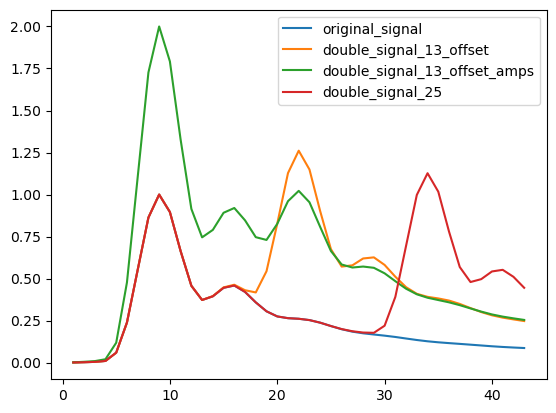

In [15]:
plotSignals(
    original_signal=exampleSignal,
    double_signal_13_offset=exampleOffset,
    double_signal_13_offset_amps=composeSignals(exampleSignal, exampleSignal, 13, 2, .5),
    double_signal_25=composeSignals(exampleSignal, exampleSignal, 25, 1, 1)
)

## Integrate composed signal

In [16]:
def integrateSignal(signal, intFrom, intTo):
    integral = 0
    for i in range(len(signal[0]) - 1):
        if signal[0][i] < intFrom or signal[0][i+1] > intTo:
            continue
        integral += (signal[1][i+1] + signal[1][i]) * (signal[0][i+1] - signal[0][i]) / 2
    return integral

In [17]:
integrateSignal(exampleOffset, 6, 28)

15.0230675825

## Roll signal amplitude

In [18]:
def rollAmp(P, E):
    # Integrate probability density to get probability
    Pint = 0
    PintArr = np.full_like(P, 0)
    assert(P[0] == 0)
    for i in range(1, len(P)): # Len preserves interoperability with Python arrays
        PintArr[i] = PintArr[i - 1] + P[i] * (E[i] - E[i - 1])
    assert(np.isclose(PintArr[-1], 1))
    
    roll = np.random.uniform() # Random roll
    
    # Convert our uniform roll into a random number, interpolate
    lowerIdx = np.where(PintArr <= roll)[0][-1]
    upperIdx = np.where(PintArr >= roll)[0][0]
    assert(lowerIdx + 1 == upperIdx)
    
    t = (roll - PintArr[lowerIdx]) / (PintArr[upperIdx] - PintArr[lowerIdx])
    return E[lowerIdx] + t * (E[upperIdx] - E[lowerIdx])

In [19]:
rollAmp(P_test, E_test)

4.911905844712216

## Test amplitude roll distribution

In [28]:
amps = [rollAmp(P_test, E_test) for i in range(100000)]

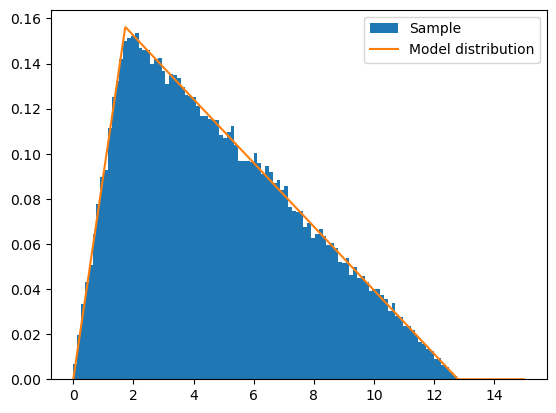

In [30]:
plt.hist(amps, bins=100, density=True, label='Sample')
plt.plot(E_test, P_test, label='Model distribution')
plt.legend()

## Complete roll

In [69]:
def testRollTwoPeaks(P, E, signal1, signal2, intFrom, intTo):
    offset = np.round(np.random.uniform(0, 41))
    amp1 = rollAmp(P, E)
    amp2 = rollAmp(P, E)
    
    return integrateSignal(composeSignals(signal1, signal2, offset, amp1, amp2), intFrom, intTo)

In [82]:
testRollTwoPeaks(P_test, E_test, exampleSignal, exampleSignal, 6, 28)

31.08025896287991

## Roll set histograms